In [ ]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Load processed dataset
df = pd.read_parquet("../datasets/processed.parquet")

#define features and response as X and y
features = ["rain", "temp", "rushhour", "weekend", "hour"]
X = df[features]
y = df["ratio"]

# Define base model. n_jobs for speed
rf = RandomForestRegressor(random_state=30034, n_jobs=-1)

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [25, 30, 35],
    "max_features": ["log2", "sqrt", None]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="r2"
)

#fit the model
grid_search.fit(X, y)



GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=30034),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [25, 30, 35],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

0.7327218741687722


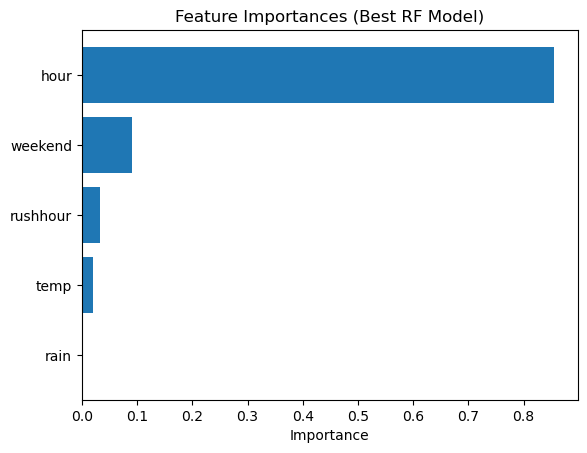

In [ ]:
#get R^2 from cross validation
y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=5)
r2   = r2_score(y, y_pred)
print(r2)

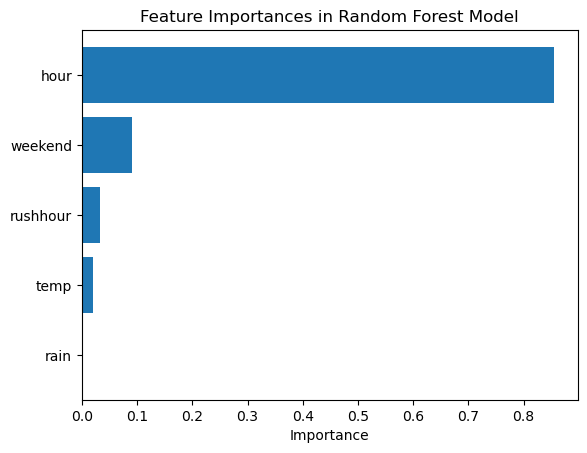

In [18]:
#plot feature importance 

importance = grid_search.best_estimator_.feature_importances_
plt.barh(features, importance)
plt.xlabel("Importance")
plt.title("Feature Importances in Random Forest Model")
plt.show()

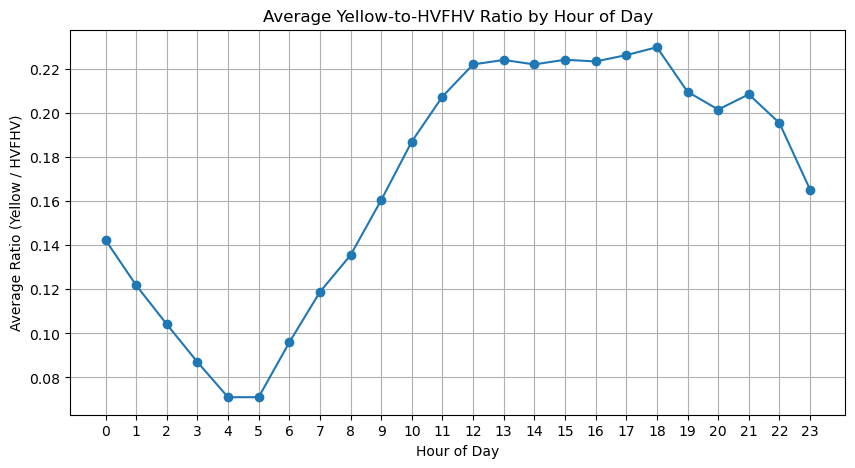

In [13]:
hourly_means = df.groupby("hour")["ratio"].mean()


plt.figure(figsize=(10,5))
plt.plot(hourly_means.index, hourly_means.values, marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hour of Day")
plt.ylabel("Average Ratio (Yellow / HVFHV)")
plt.title("Average Yellow-to-HVFHV Ratio by Hour of Day")
plt.grid(True)
plt.show()

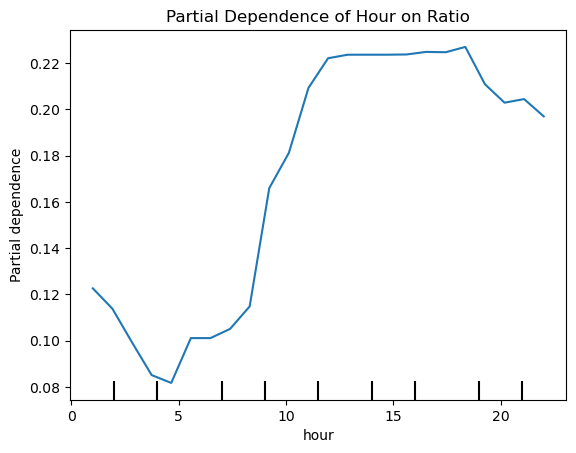

In [14]:
from sklearn.inspection import PartialDependenceDisplay

best_rf = grid_search.best_estimator_

PartialDependenceDisplay.from_estimator(
    best_rf, X, ["hour"], grid_resolution=24
)
plt.title("Partial Dependence of Hour on Ratio")
plt.show()

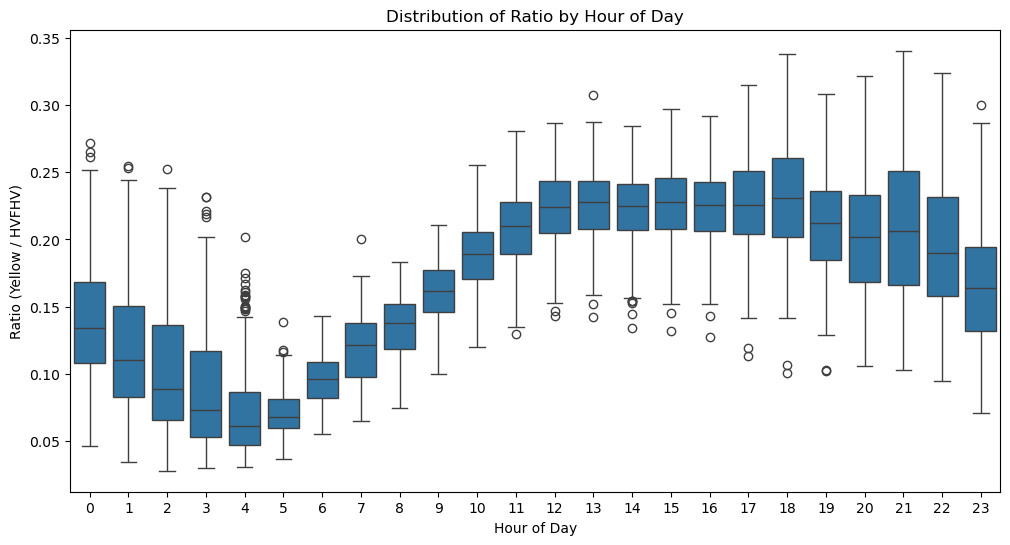

In [15]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="hour", y="ratio", data=df)
plt.xlabel("Hour of Day")
plt.ylabel("Ratio (Yellow / HVFHV)")
plt.title("Distribution of Ratio by Hour of Day")
plt.show()

In [16]:
rf_with_hour = grid_search.best_estimator_
rf_with_hour.fit(X, y)
print("R² with hour:", rf_with_hour.score(X, y))

# Model WITHOUT hour
X_nohour = X.drop(columns=["hour"])
rf_nohour = RandomForestRegressor(
    **grid_search.best_params_, random_state=42
)
rf_nohour.fit(X_nohour, y)
print("R² without hour:", rf_nohour.score(X_nohour, y))

R² with hour: 0.8183358345690463
R² without hour: 0.1373834162001052
